In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('2020_WSB.csv')

In [3]:
# 1ST TEST - credibility
df_response = df[(df.score != 1) & (df.upvote != 1)]
df_response = df_response[(df_response.domain != 'reddit.com')]
# content type (image, video etc.)
df_response['content'] = df_response.domain.apply(lambda x: 'text' if x == 'self.wallstreetbets' 
                      else('image' if x == 'i.redd.it' 
                           else('gif' if x in ['i.imgur.com', 'imgur.com'] 
                                else('video' if x in ['v.redd.it', 'youtu.be', 'youtube.com'] else 'news'))))
df_response['body'][(df_response['body'] == '[removed]') 
                    | (df_response['body'] == '[deleted]') 
                    | (df_response['body'].isnull() == True)] = df_response['content']
df_response['body'][df_response['body'] == 'text'] = ''
df_response['fulltext'] = df_response['title'] + ' ' + df_response['body']
# credit
upvote75 = df_response['upvote'].quantile(0.75)
score75 = df_response['score'].quantile(0.75)
def conditions(s):
    if (s['score'] >= score75) and (s['upvote'] >= upvote75):
        return 'HIGH'
    else:
        return 'LOW'
df_response['credibility'] = df_response.apply(conditions, axis = 1)

<ipython-input-3-799097ac6e58>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_response['body'][(df_response['body'] == '[removed]')
<ipython-input-3-799097ac6e58>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_response['body'][df_response['body'] == 'text'] = ''


In [4]:
X = df_response.loc[:,['fulltext']]
y = df_response.credibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [5]:
X_train_docs = [doc for doc in X_train.fulltext]
vect = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_features=3000,token_pattern=r'\b[^_\d\W]+\b').fit(X_train_docs)
X_train_features = vect.transform(X_train_docs)

In [6]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 100 features:\n{}".format(feature_names[:100]))
print("Every 100th feature:\n{}".format(feature_names[::100]))

Number of features: 3000
First 100 features:
['aal', 'aapl', 'ability', 'able', 'absolute', 'absolutely', 'acb', 'access', 'according', 'account', 'accounting', 'accounts', 'accurate', 'ackman', 'acquire', 'acquired', 'acquisition', 'act', 'action', 'actions', 'active', 'activity', 'actual', 'actually', 'ad', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'adjusted', 'administration', 'ads', 'advance', 'advanced', 'advantage', 'advertising', 'advice', 'af', 'affect', 'affected', 'afford', 'afternoon', 'age', 'aggressive', 'ago', 'agree', 'agreement', 'ah', 'ahead', 'ai', 'aid', 'ain', 'ain t', 'air', 'airbnb', 'airline', 'airlines', 'aka', 'alert', 'algos', 'alibaba', 'allow', 'allowed', 'allows', 'alright', 'alternative', 'amazing', 'amazon', 'amc', 'amd', 'america', 'american', 'americans', 'ameritrade', 'amid', 'amounts', 'amp', 'amp amp', 'amp s', 'amzn', 'analysis', 'analyst', 'analysts', 'announce', 'announced', 'announcement', 'announces', 'annual', 'answer'

In [ ]:
lin_svc = LinearSVC()
scores = cross_val_score(lin_svc, X_train_features, y_train, cv=5)

In [112]:
print("mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

mean cross-validation accuracy: 0.80


In [119]:
# lin_svc.fit(X_train_features, y_train)
clf = CalibratedClassifierCV(lin_svc)
clf.fit(X_train_features, y_train)
X_test_docs = [doc for doc in X_test.fulltext]
X_test_features = vect.transform(X_test_docs)
y_test_pred = clf.predict(X_test_features)

In [120]:
print("test set validation accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))

test set validation accuracy: 0.81


<AxesSubplot:xlabel='Predicted', ylabel='True'>

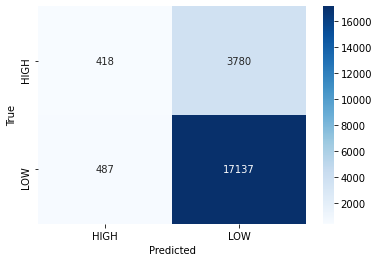

In [60]:
# m1 = np.array(y_test.apply(lambda x :1 if x == 'HIGH' else 0))
# m2 = np.array(pd.DataFrame(y_test_pred).squeeze().apply(lambda x :1 if x == 'HIGH' else 0))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
df_cm = df_cm.rename({0: 'HIGH', 1: 'LOW'}, axis='index').rename({0: 'HIGH', 1: 'LOW'}, axis='columns')
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'
sn.heatmap(df_cm, annot = True,fmt='g', cmap=plt.cm.Blues)

In [137]:
a = X_test.iloc[-1]
a['fulltext'] = 'gme hold image'
# a_docs = [doc for doc in a.fulltext]
a_f = vect.transform(a)
a_f

<1x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [139]:
clf.predict(a_f)

array([[0.33836824, 0.66163176]])

In [136]:
clf.predict_proba(a_f)

array(['HIGH'], dtype=object)